# Elo Merchant Category Recommendation - Outlier detection, ensembling
End date: _2019. february 19._<br/>

This tutorial notebook is part of a series for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. LynxKite does not yet support some of the data preprocessing, thus they need to be done in Python. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import gc
import time
import warnings
import datetime
import calendar
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from datetime import date
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
gc.enable()

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Input data preparation
### Transactions

In [3]:
df_new_trans = pd.read_csv("preprocessed/trans_merch_new_agg.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

df_hist_trans = pd.read_csv("preprocessed/trans_merch_hist_agg.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 289.84 MB
Reduced memory usage: 70.52 MB (75.7% reduction)
Starting memory usage: 325.36 MB
Reduced memory usage: 96.86 MB (70.2% reduction)


In [4]:
df_hist_trans.drop(['Unnamed: 0'], inplace=True, axis=1)
df_new_trans.drop(['Unnamed: 0'], inplace=True, axis=1)

### Train and test data

In [5]:
df_train = pd.read_csv("preprocessed/train_parsed_outlier_marked.csv", index_col="card_id")
df_test = pd.read_csv("preprocessed/test_parsed.csv", index_col="card_id")

### LynxKite export

In [6]:
df_lk_train = pd.read_csv("LynxKite_export/LynxKite_outlier_viral_modeling_train.csv", index_col="card_id")
df_lk_test = pd.read_csv("LynxKite_export/LynxKite_outlier_viral_modeling_test.csv", index_col="card_id")

In [7]:
df_lk_train.drop(['new_id', 'outlier', 'target', 'type'], inplace=True, axis=1)
df_lk_test.drop(['new_id', 'outlier', 'target', 'type'], inplace=True, axis=1)

### Merging

In [8]:
df_train = pd.merge(df_train, df_lk_train, on='card_id', how='left')
df_test = pd.merge(df_test, df_lk_test, on='card_id', how='left')

In [9]:
df_train = pd.merge(df_train, df_hist_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_hist_trans, on='card_id', how='left')

df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

In [10]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Starting memory usage: 212.97 MB
Reduced memory usage: 127.67 MB (40.1% reduction)
Starting memory usage: 128.51 MB
Reduced memory usage: 81.70 MB (36.4% reduction)


## Outlier selection
[6 Ways for Feature Selection](https://www.kaggle.com/sz8416/6-ways-for-feature-selection)

### Remove correlating features
[Drop Highly Correlated Features](https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/)

In [11]:
columns2drop = ['card_id', 'outlier', 'first_active_month', 'viral_outlier_test', 'viral_outlier_train', 'viral_roles',
                'hist_avg_purchases_lag3_sum', 'hist_avg_purchases_lag3_mean', 'hist_avg_purchases_lag6_sum',
                'hist_avg_purchases_lag6_mean', 'hist_avg_purchases_lag12_sum', 'hist_avg_purchases_lag12_mean',
                'viral_outlier_spread_over_iterations', 'hist_transactions_count', 'hist_purchase_year_min',
                'new_transactions_count', 'new_authorized_flag_mean']

features_train = [c for c in df_train.columns if c not in columns2drop]
columns2drop.remove('card_id')
features_test = [c for c in df_test.columns if c not in columns2drop]

In [12]:
df_train_clean = df_train[features_train]
df_test_clean = df_test[features_test]

In [13]:
df_train_clean.shape[1], df_test_clean.shape[1]

(275, 275)

In [14]:
corr_matrix = df_train_clean.corr().abs()

In [15]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [16]:
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
len(to_drop)

122

In [17]:
df_train_clean = df_train_clean.drop(to_drop, axis=1)
df_test_clean = df_test_clean.drop(to_drop, axis=1)

In [18]:
print('There are {:} features in the original training set, {:} features in the non-correlating training set.'.format(df_train.shape[1], df_train_clean.shape[1]))
print('There are {:} features in the original test set, {:} features in the non-correlating test set.'.format(df_test.shape[1], df_test_clean.shape[1]))

There are 292 features in the original training set, 153 features in the non-correlating training set.
There are 290 features in the original test set, 153 features in the non-correlating test set.


In [19]:
features_train = list(df_train_clean.columns)
features_train.remove('target')
features_test = list(df_test_clean.columns)
features_test.remove('card_id')

### Marking the outliers

In [11]:
df_train['outlier'] = np.where(df_train['target']<-30, 1, 0)

In [12]:
print('There are {:,} marked outliers in the training set.'.format(len(df_train[df_train['outlier'] == 1]['outlier'])))

There are 2,207 marked outliers in the training set.


### Normalization

In [20]:
len(features_train), len(columns2drop)

(185, 17)

In [21]:
df_train_clean = df_train.dropna(how='any', axis=0, subset=features_train)[features_train]

In [22]:
def normalize(df):
    for c in df.columns:
        mean = statistics.mean(df[c])
        std = statistics.stdev(df[c])

        df.loc[:, c] = (df[c] - mean)/std
        print('{}: {:.4f} ({:.4f})'.format(c, mean, std))

    return df

In [ ]:
y = df_train_clean['outlier']
print('There are {:,} records in the outlier set.'.format(len(y)))

df_train_clean.drop(['outlier'], axis=1, inplace=True)
X = normalize(df_train_clean)
print('There are {:,} features and {:,} items in the training set.'.format(X.shape[1], X.shape[0]))

There are 148,692 records in the outlier set.
feature_1: 3.0882 (1.1964)
feature_2: 1.7320 (0.7500)
feature_3: 0.5536 (0.4971)
elapsed_days: 361.1784 (285.6945)
year: 2016.5548 (0.7575)
month: 7.5153 (3.3239)
days_feature1: 1153.4269 (1084.3276)
days_feature2: 657.5544 (707.5473)
days_feature3: 226.3963 (318.3985)
number_of_transactions_x: 100.5018 (112.8207)
merch_seg_viral_outlier_average_after_iteration_1_most_common: 0.0029 (0.0322)
merch_seg_viral_outlier_average_after_iteration_2_most_common: 0.0018 (0.0243)
merch_seg_viral_outlier_standard_deviation_after_iteration_1_most_common: 0.0106 (0.0462)
merch_seg_viral_outlier_standard_deviation_after_iteration_2_most_common: 0.0078 (0.0356)
viral_outlier_after_iteration_1: 0.0063 (0.0780)
hist_authorized_flag_mean: 0.9026 (0.1030)
hist_active_months_lag3_mean: 2.9997 (0.0049)
hist_active_months_lag6_mean: 5.9979 (0.0194)
hist_active_months_lag12_mean: 11.7382 (0.3147)
hist_avg_sales_lag3_sum: 12948.6261 (150512.9370)
hist_avg_sales_lag

In [ ]:
X.shape, y.shape

In [ ]:
X.isnull().sum()

### Feature selection of outlier selection

#### Pearson correlation

In [29]:
def cor_selector(X, y, limit=100):
    cor_list = []
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-limit:]].columns.tolist()
    cor_support = [True if i in cor_feature else False for i in X.columns.tolist()]
    return cor_support, cor_feature, cor_list

In [30]:
cor_support, cor_feature, cor_value = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

100 selected features


#### Chi-2

In [31]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest

X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float16, float32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


SelectKBest(k=100, score_func=<function chi2 at 0x7f7960863bf8>)

In [32]:
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

100 selected features


#### RFE

In [33]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=5, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

Fitting estimator with 184 features.
Fitting estimator with 174 features.
Fitting estimator with 164 features.
Fitting estimator with 154 features.
Fitting estimator with 144 features.
Fitting estimator with 134 features.
Fitting estimator with 124 features.
Fitting estimator with 114 features.
Fitting estimator with 104 features.
Fitting estimator with 94 features.
Fitting estimator with 84 features.
Fitting estimator with 74 features.
Fitting estimator with 64 features.
Fitting estimator with 54 features.
Fitting estimator with 44 features.
Fitting estimator with 34 features.
Fitting estimator with 24 features.
Fitting estimator with 14 features.


RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
  n_features_to_select=5, step=10, verbose=5)

In [34]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

5 selected features


#### Embedded

In [35]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1"), '1.25*median')
embeded_lr_selector.fit(X_norm, y)

SelectFromModel(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False,
        threshold='1.25*median')

In [36]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

184 selected features


#### Random Forest

In [37]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=5), threshold='1.25*median')
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        max_features=None, norm_order=1, prefit=False,
        threshold='1.25*median')

In [38]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

63 selected features


#### LightGBM

In [39]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.2,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        min_child_samples=20, min_child_weight=40, min_split_gain=0.01,
        n_estimators=500, n_jobs=-1, num_leaves=32, objective=None,
        random_state=None, reg_alpha=3, reg_lambda=1, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
        max_features=None, norm_order=1, prefit=False,
        threshold='1.25*median')

In [40]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

72 selected features


#### LightGBM 2.
[Outlier handling strategies](https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/78470)

In [ ]:
def custom_asymmetric_train(preds, train_data):
    y_true = train_data.get_label()
    residualtrain: = (y_true - y_pred).astype("float")
    grad = -4*residual**3
    hess = 12*residual**2

    return grad, hess

def custom_asymmetric_valid(preds, train_data):
    y_true = train_data.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = residual**5

    return "custom_asymmetric_eval", np.mean(loss), False

model = lgb.train({
        'boosting_type': 'gbdt',
        'objective': 'None',
        'metric': 'None',
        'learning_rate': 0.05
    },
    df_train_clean,
    num_boost_round=10,
    fobj=custom_asymmetric_train,
    feval=custom_asymmetric_valid,
    #valid_sets=eval_set
)

#### Evaluation

In [41]:
pd.set_option('display.max_rows', None)

feature_selection_df = pd.DataFrame({
    'feature': X.columns.tolist(),
    'Pearson': cor_support,
    'Chi-2': chi_support,
    'RFE': rfe_support,
    'Logistics': embeded_lr_support,
    'Random Forest': embeded_rf_support,
    'LightGBM': embeded_lgb_support
})

feature_selection_df['total'] = np.sum(feature_selection_df, axis=1)

feature_selection_df = feature_selection_df.sort_values(['total', 'feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df[:50]

,feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,total
1,viral_outlier_after_iteration_1,True,True,True,True,True,True,6
2,new_purchase_weekofyear_nunique,True,True,True,True,False,True,5
3,new_purchase_quarter_max,True,True,False,True,True,True,5
4,new_purchase_month_mean,True,True,False,True,True,True,5
5,new_purchase_hour_std,True,True,False,True,True,True,5
6,new_purchase_dayofweek_std,True,True,False,True,True,True,5
7,new_purchase_day_std,True,True,False,True,True,True,5
8,new_purchase_day_median,True,True,False,True,True,True,5
9,new_purchase_day_mean,True,True,False,True,True,True,5
10,new_purchase_day_max,True,True,False,True,True,True,5


In [90]:
len(feature_selection_df[feature_selection_df['total'] > 4]['feature'])

31

In [91]:
features = list(feature_selection_df[feature_selection_df['total'] > 4]['feature'])
features

['viral_outlier_after_iteration_1',
 'new_purchase_weekofyear_nunique',
 'new_purchase_quarter_max',
 'new_purchase_month_mean',
 'new_purchase_hour_std',
 'new_purchase_dayofweek_std',
 'new_purchase_day_std',
 'new_purchase_day_median',
 'new_purchase_day_mean',
 'new_purchase_day_max',
 'new_number_of_transactions_median',
 'new_number_of_transactions_mean',
 'new_month_lag_mean',
 'month',
 'merch_seg_viral_outlier_standard_deviation_after_iteration_2_most_common',
 'merch_seg_viral_outlier_standard_deviation_after_iteration_1_most_common',
 'merch_seg_viral_outlier_average_after_iteration_2_most_common',
 'merch_seg_viral_outlier_average_after_iteration_1_most_common',
 'hist_purchase_year_std',
 'hist_purchase_year_max',
 'hist_purchase_month_std',
 'hist_month_lag_mean',
 'hist_installments_sum',
 'hist_category_4_mean',
 'hist_category_3_sum',
 'hist_category_1_trans_sum',
 'hist_category_1_trans_mean',
 'hist_category_1_merch_sum',
 'hist_category_1_merch_mean',
 'hist_authori

### Feature selection of training set

In [ ]:
# all features
#features = [c for c in df_train.columns if c not in columns2drop]

features.append('outlier')

df_train_clean = df_train.dropna(how='any', axis=0, subset=features)[features]
y = df_train_clean.outlier

df_train_clean.drop(['outlier'], axis=1, inplace=True)
X = normalize(df_train_clean)

features_test = features
features_test.remove('outlier')
features_test.append('card_id')
df_test_clean = df_test.dropna(how='any', axis=0, subset=features_test)[features_test]

In [ ]:
X.shape, y.shape, df_test_clean.shape

In [ ]:
features_test.remove('card_id')

#### Random Forest

In [95]:
clf = RandomForestClassifier(verbose=1)
clf.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [96]:
randomforest_outlier_pred = clf.predict(df_test_clean[features_test])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [97]:
randomforest_outlier_pred.sum()

0

In [98]:
rf_outlier_card_ids = []
for i in range(len(randomforest_outlier_pred)):
    if randomforest_outlier_pred[i] == 1:
        print('{:,}. card_id: {}'.format(i, df_test_clean['card_id'].iloc[i]))
        rf_outlier_card_ids.append(df_test_clean['card_id'].iloc[i])

In [99]:
rf_outlier_card_ids

[]

#### Logistic regression

In [100]:
clf = LogisticRegression(verbose=1)
clf.fit(X, y)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=1, warm_start=False)

In [101]:
logistic_regression_outlier_pred = clf.predict(df_test_clean[features_test])

In [102]:
logistic_regression_outlier_pred.sum()

11

In [103]:
lr_outlier_card_ids = []
for i in range(len(logistic_regression_outlier_pred)):
    if logistic_regression_outlier_pred[i] == 1:
        print('{:,}. card_id: {}'.format(i, df_test_clean['card_id'].iloc[i]))
        lr_outlier_card_ids.append(df_test_clean['card_id'].iloc[i])

3,487. card_id: C_ID_c0b4e08398
7,825. card_id: C_ID_fd158a8b90
26,981. card_id: C_ID_6d7769f9a9
36,010. card_id: C_ID_34aa1d9963
45,790. card_id: C_ID_a777236765
49,412. card_id: C_ID_6ba5524817
51,629. card_id: C_ID_c9a8d6baa9
55,225. card_id: C_ID_a2f2be2611
70,382. card_id: C_ID_cdce5657d9
71,233. card_id: C_ID_2e0ac7da4e
90,515. card_id: C_ID_c3ed09b27d


#### AdaBoost

In [104]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()
clf.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [105]:
adaboost_outlier_pred = clf.predict(df_test_clean[features_test])

In [106]:
adaboost_outlier_pred.sum()

0

In [107]:
adaboost_outlier_card_ids = []
for i in range(len(adaboost_outlier_pred)):
    if adaboost_outlier_pred[i] == 1:
        print('{:,}. card_id: {}'.format(i, df_test_clean['card_id'].iloc[i]))
        adaboost_outlier_card_ids.append(df_test_clean['card_id'].iloc[i])

### Ensembling

In [108]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [109]:
print('Size of the output of the logistic regression: {}\nSize of the output of the random forest: {}\nSize of the output of the AdaBoost: {}'.format(len(lr_outlier_card_ids), len(rf_outlier_card_ids), len(adaboost_outlier_card_ids)))

Size of the output of the logistic regression: 11
Size of the output of the random forest: 0
Size of the output of the AdaBoost: 0


In [110]:
intersection(lr_outlier_card_ids, rf_outlier_card_ids)

[]

In [111]:
intersection(lr_outlier_card_ids, adaboost_outlier_card_ids)

[]

In [112]:
intersection(rf_outlier_card_ids, adaboost_outlier_card_ids)

[]

## Training
LightGBM training without outliers

In [20]:
df_train_clean.shape[1], df_test_clean.shape[1]

(153, 153)

[LightGBM parameters](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst)<br/>
[Comparison between LGB boosting methods (goss, gbdt and dart)](https://www.kaggle.com/c/home-credit-default-risk/discussion/60921)

In [21]:
target = df_train_clean['target']
df_train_clean = df_train_clean.drop(['target'], axis=1)

In [22]:
df_train_clean.shape, target.shape, df_test_clean.shape

((201917, 152), (201917,), (123623, 153))

In [51]:
features = list(df_train_clean.columns)

In [27]:
param = {
    'num_leaves': 127,
    'min_data_in_leaf': 20, 
    'objective': 'regression_l2',
    'max_depth': -1,
    'learning_rate': 0.01,
    "boosting": "dart",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train_clean))
predictions = np.zeros(len(df_test_clean))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train_clean.values, target.values)):
    print("Fold {}.".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train_clean.iloc[trn_idx], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train_clean.iloc[val_idx], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train_clean.iloc[val_idx], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features_train
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features_test], num_iteration=clf.best_iteration) / folds.n_splits

Fold 1.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.02201	valid_1's rmse: 3.06874
[200]	training's rmse: 2.75042	valid_1's rmse: 2.81028
[300]	training's rmse: 2.50437	valid_1's rmse: 2.57954
[400]	training's rmse: 2.34652	valid_1's rmse: 2.44063
[500]	training's rmse: 2.22318	valid_1's rmse: 2.33729
[600]	training's rmse: 2.20662	valid_1's rmse: 2.32944
[700]	training's rmse: 2.13772	valid_1's rmse: 2.27771
[800]	training's rmse: 2.10913	valid_1's rmse: 2.26048
[900]	training's rmse: 2.06402	valid_1's rmse: 2.23272
[1000]	training's rmse: 2.04356	valid_1's rmse: 2.22419
[1100]	training's rmse: 2.01847	valid_1's rmse: 2.21462
Early stopping, best iteration is:
[1045]	training's rmse: 2.02336	valid_1's rmse: 2.2135
Fold 2.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.04181	valid_1's rmse: 2.98727
[200]	training's rmse: 2.77018	valid_1's rmse: 2.72602
[300]	training's rmse: 2.52399	valid_1's rmse: 2.49

In [28]:
cross_validation_lgb = np.sqrt(mean_squared_error(target, oof))
print('Cross-validation score: ' + str(cross_validation_lgb))

Cross-validation score: 2.2877215814901817


/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


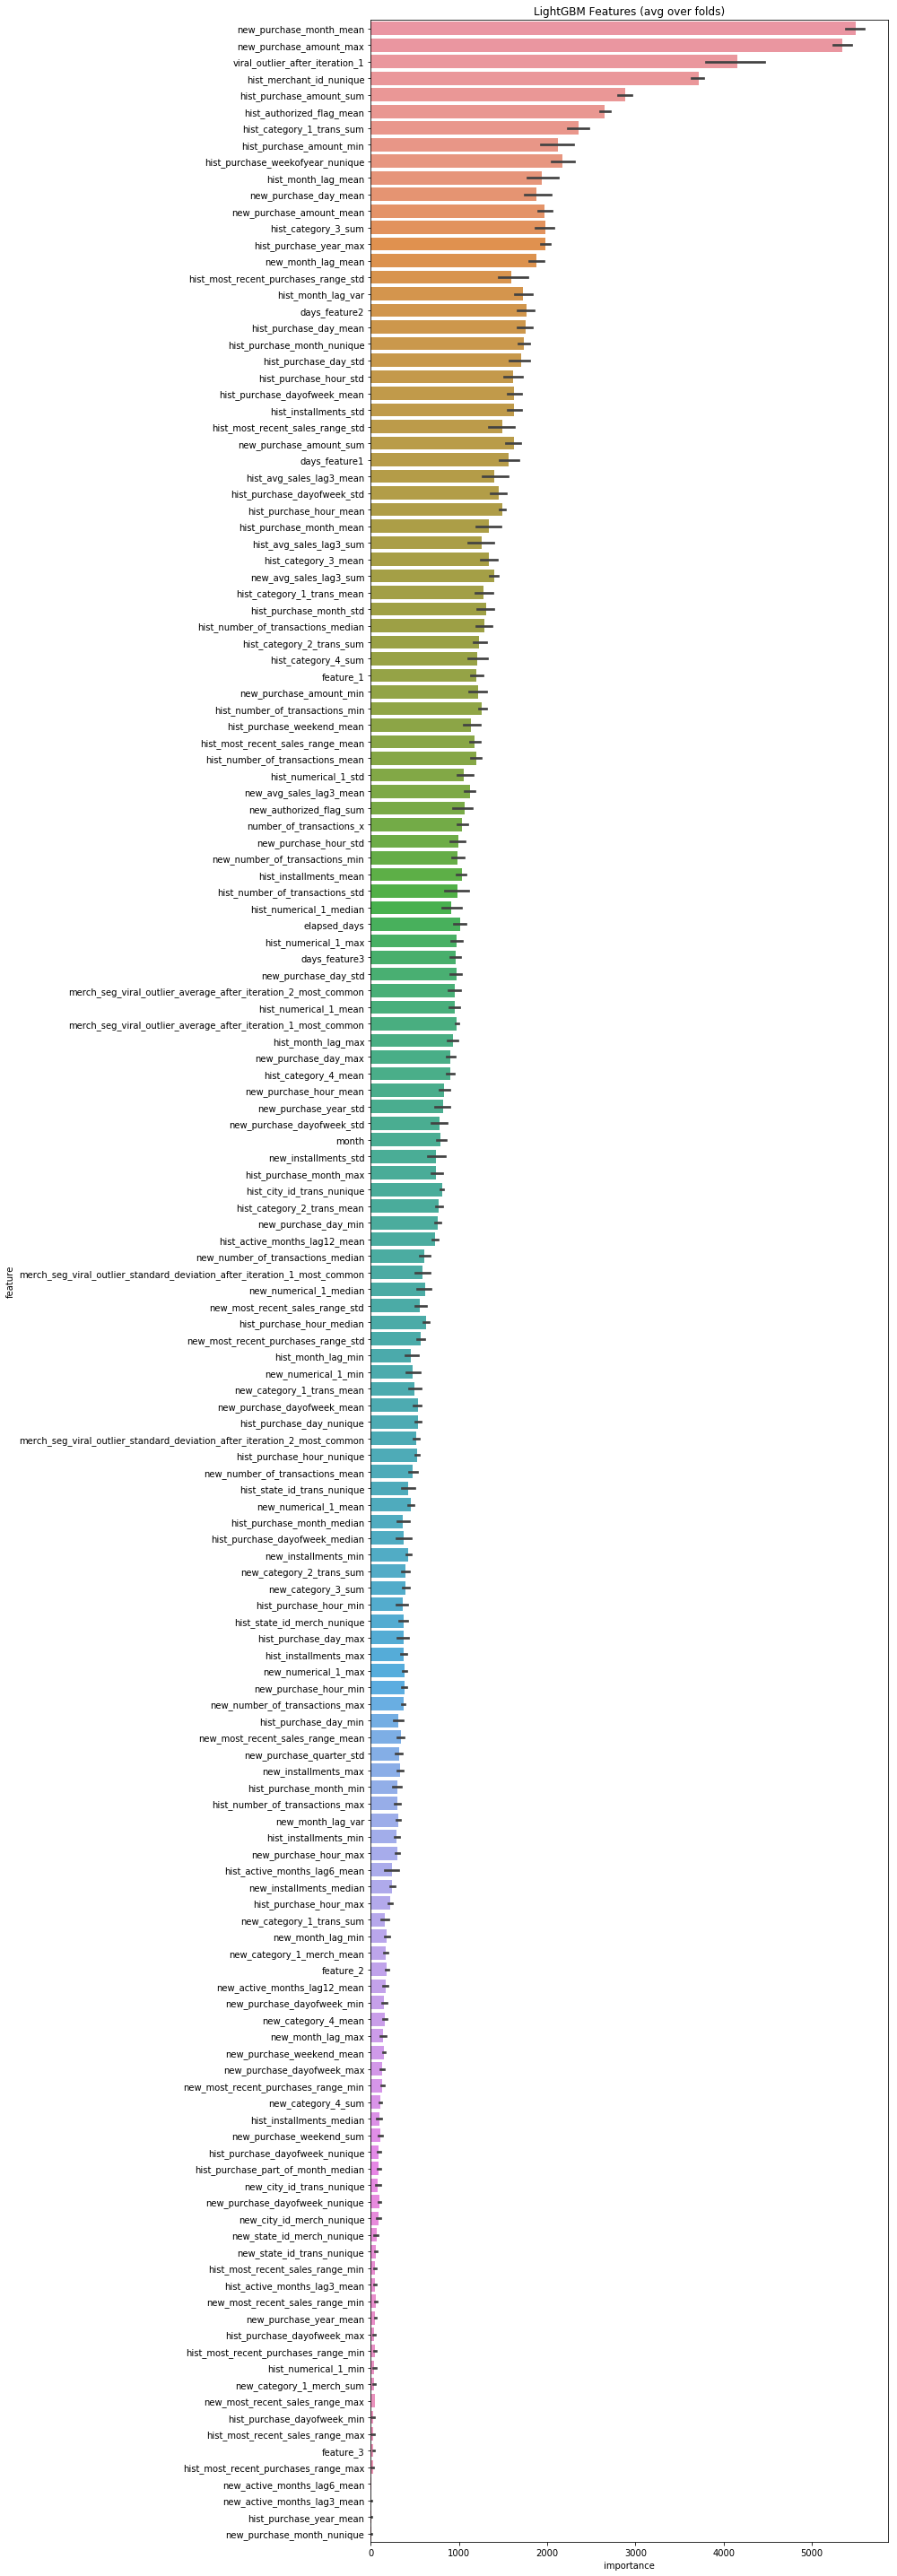

In [29]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [30]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/lgbm_{}.csv".format(cross_validation_lgb), index=False)

## Prediction
Load the model that was trained on the training set without outliers.

In [ ]:
clf = lgb.Booster(model_file='models/lightgbm_all.txt')

In [ ]:
drops = ['card_id', 'first_active_month', 'target', 'outlier']
use_cols = [c for c in df_train.columns if c not in drops]
features = list(df_train[use_cols].columns)

In [ ]:
predictions = clf.predict(df_test[features])

In [ ]:
df_sub = pd.DataFrame({
    "card_id": df_test["card_id"].values
})
df_sub["target"] = predictions

In [132]:
print('-10 x log2(10) = {:.8f}'.format(-10*np.log2(10)))

-10 x log2(10) = -33.21928095


In [ ]:
# Updating the intersection of Logistic regression & Random Forest
df_sub.loc[df_sub['card_id'] == 'C_ID_aae50409e7', 'target'] = -33.218750

In [ ]:
for i in range(len(lr_outlier_card_ids)):
    print('The value of {} is {}'.format(lr_outlier_card_ids[i], df_sub.loc[df_sub['card_id'] == lr_outlier_card_ids[i], 'target'].values[0]))
    df_sub.loc[df_sub['card_id'] == lr_outlier_card_ids[i], 'target'] = -33.218750

In [ ]:
len(df_sub[df_sub['target'] < -30])

In [ ]:
df_sub.to_csv("output/lgbm_rf_and_adaboost_outliers.csv", index=False)

* Random Forest (LB score: 5.994)
* Logistic Regression (LB score: 5.990)
* Random Forest & AdaBoost (LB score: 5.986)